In [1]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from scipy import io as sio
from tensorflow.python.framework import ops
from dfs2 import DeepFeatureSelectionNew
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Imputer

# data_All = sio.loadmat("../data/GSE44772_data_refined.mat")

data_PFC = sio.loadmat("../data/GSE44772_PFC_refined.mat")
data_VC = sio.loadmat("../data/GSE44772_VC_refined.mat")
data_CR = sio.loadmat("../data/GSE44772_CR_refined.mat")

info_PFC = sio.loadmat("../data/PFC_IG_refined.mat")
info_VC = sio.loadmat("../data/VC_IG_refined.mat")
info_CR = sio.loadmat("../data/CR_IG_refined.mat")

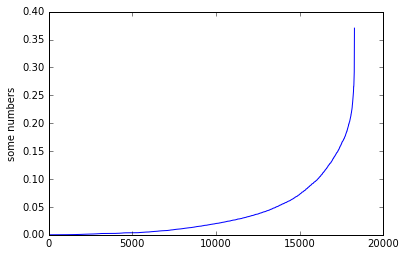

In [8]:
%matplotlib inline

# np.argsort(info_PFC['gmm']['ig'][0][0][0])
# info_PFC['median']['ig'][0][0][0]

import matplotlib.pyplot as plt
plt.plot(np.sort(info_VC['gmm']['ig'][0][0][0]))
plt.ylabel('some numbers')
plt.show()

In [9]:
index_gmm_PFC = np.argsort(info_PFC['gmm']['ig'][0][0][0])[-10000:]
index_median_PFC = np.argsort(info_PFC['median']['ig'][0][0][0])[-10000:]

index_gmm_VC = np.argsort(info_VC['gmm']['ig'][0][0][0])[-10000:]
index_median_VC = np.argsort(info_VC['median']['ig'][0][0][0])[-10000:]

index_gmm_CR = np.argsort(info_CR['gmm']['ig'][0][0][0])[-10000:]
index_median_CR = np.argsort(info_CR['median']['ig'][0][0][0])[-10000:]

In [ ]:
data_VC['X'].shape

In [ ]:
def setRegion(region):
    if region == 'PFC':
        ourdata = data_PFC
    elif region == 'VC':
        ourdata = data_VC
    elif region == 'CR':
        ourdata = data_CR
    elif region == 'All':
        ourdata = data_All
        
    inputX = ourdata['X']
    # Inpute using median
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(inputX)
    inputX = imp.transform(inputX)
    
    inputY = ourdata['y'][0,:]
    
    return inputX, inputY

In [ ]:
inputX, inputY = setRegion('CR')

In [ ]:
ig(inputX, inputY)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputX, inputY, test_size=0.2, random_state=1)

dfsMLP = DeepFeatureSelectionNew(X_train, X_test, y_train, y_test, n_input=1, hidden_dims=[100], dropout=[False], \
                                 learning_rate=0.01, lambda1=0.001, lambda2=1, alpha1=0.1, alpha2=0, activation='tanh', weight_init='uniform', \
                                 epochs=100, optimizer='Adam', print_step=10)

dfsMLP.train(batch_size=200)

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC

svm = LinearSVC()

# All cross validation 0.900105526433
# PFC cross validation 0.90895672731
# VC cross validation 0.913401171755
# CR cross validation 0.904520505705

# keke, keke_test = topDFSfeatures(0,150)
scores = cross_val_score(svm, inputX, inputY, cv=5)
print(np.mean(scores))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

rf = RandomForestClassifier(criterion="entropy", n_estimators = 300, max_depth = 5)
for region in ['All','CR','PFC','VC']:
    inputX, inputY = setRegion(region)
    scores = cross_val_score(rf, inputX, inputY, cv=5)
    print(region + "cross validation result:" + str(np.mean(scores)))

# gbm = xgb.XGBClassifier(max_depth=5, n_estimators=400, learning_rate=0.05).fit(top_train, y_train)
# y_pred = gbm.predict(top_test)

# featurescores = gbm.feature_importances_

# print(accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.cross_validation import KFold

# All XGBoost cross validation result:0.882608695652

for region in ['CR','PFC','VC']:
    inputX, inputY = setRegion(region)
    scores = []
    for train_index, test_index in kf:
        kf = KFold(n=inputX.shape[0], n_folds=5, shuffle=True, random_state=44)
        X_train, X_test, y_train, y_test = inputX[train_index], inputX[test_index], inputY[train_index], inputY[test_index]
        gbm = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
        y_pred = gbm.predict(X_test)
    #     featurescores = gbm.feature_importances_
        scores.append(accuracy_score(y_test, y_pred))
    print(region + " XGBoost cross validation result:" + str(np.mean(scores)))

In [ ]:
kf = KFold(n=inputX.shape[0], n_folds=5, shuffle=True, random_state=44)

kf

1. MI
2. Top 100
3. GO analysis, pathway analysis

In [ ]:
for train_index, test_index in kf:
    print test_index

In [ ]:
weight = dfsMLP.selected_ws[0]
index = np.argsort(abs(weight))[::-1]

In [ ]:
for i in xrange(6):
    print(len(inputY[inputY==i]))

In [ ]:
def topDFSfeatures(a,b):
    return X_train[:, index.tolist()[a:b]], X_test[:, index.tolist()[a:b]]

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC

svm = LinearSVC()

keke, keke_test = topDFSfeatures(0,150)
scores = cross_val_score(svm, keke, y_train, cv=5)
print(np.mean(scores))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

top_train, top_test = topDFSfeatures(0,500)

rf = RandomForestClassifier(criterion="entropy", n_estimators = 300, max_depth = 5)
rf.fit(top_train, y_train)

y_pred = rf.predict(top_test)

print(accuracy_score(y_test, y_pred))

gbm = xgb.XGBClassifier(max_depth=5, n_estimators=400, learning_rate=0.05).fit(top_train, y_train)
y_pred = gbm.predict(top_test)

featurescores = gbm.feature_importances_

print(accuracy_score(y_test, y_pred))

# gbm10 = xgb.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.05).fit(X_train10, y_train)
# y_pred10 = gbm.predict(X_test10)

# print(accuracy_score(y_test, y_pred))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(inputX, inputY, test_size=0.2, random_state=1)

top_train, top_test = topDFSfeatures(20000,30000)

dfsMLP = DeepFeatureSelectionNew(top_train, top_test, y_train, y_test, n_input=1, hidden_dims=[100], dropout=[False], \
                                 learning_rate=0.01, lambda1=0.001, lambda2=1, alpha1=0.01, alpha2=0, activation='tanh', weight_init='uniform', \
                                 epochs=100, optimizer='Adam', print_step=5)
dfsMLP.train(batch_size=200)

In [ ]:
import numpy as np
from scipy.sparse import issparse
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_array
from sklearn.utils.extmath import safe_sparse_dot


from math import log

def I(p,n):
	pos = p / (p + n)
	neg = n / (p + n)
	
	if pos == 0 and neg == 0:
		return 0
	elif pos == 0:
		return -neg * log(neg, 2)
	elif neg == 0:
		return -pos * log(pos, 2)
	else:
		return (-pos * log(pos, 2)) + (-neg * log(neg, 2))